In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from collections import Counter
from sklearn.model_selection import cross_val_score
import re
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')
import os

Using TensorFlow backend.


In [3]:
train=pd.read_csv('train.csv')
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [5]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [6]:
train.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


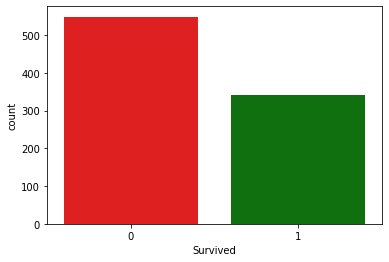

0    549
1    342
Name: Survived, dtype: int64


In [8]:
sns.countplot(train['Survived'],palette=['red','green'])
plt.show()
print(train.Survived.value_counts())

In [15]:
def detect_outliers(df,features):
    outlier_indices = []
    
    for c in features:
        Q1 = np.percentile(df[c],25)
        Q3 = np.percentile(df[c],75)
        IQR = Q3 - Q1
        outlier_step = IQR * 1.5
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2) 
    
    return multiple_outliers

In [16]:
train.loc[detect_outliers(train,["Age","SibSp","Parch","Fare"])]

PassengerId  Survived  Pclass                               Name     Sex  \
27            28         0       1     Fortune, Mr. Charles Alexander    male   
88            89         1       1         Fortune, Miss. Mabel Helen  female   
159          160         0       3         Sage, Master. Thomas Henry    male   
180          181         0       3       Sage, Miss. Constance Gladys  female   
201          202         0       3                Sage, Mr. Frederick    male   
324          325         0       3           Sage, Mr. George John Jr    male   
341          342         1       1     Fortune, Miss. Alice Elizabeth  female   
792          793         0       3            Sage, Miss. Stella Anna  female   
846          847         0       3           Sage, Mr. Douglas Bullen    male   
863          864         0       3  Sage, Miss. Dorothy Edith "Dolly"  female   

      Age  SibSp  Parch    Ticket    Fare        Cabin Embarked  
27   19.0      3      2     19950  263.00  C23 C25 C27        S  
88   23.0      3      2     19950  263.00  C23 C25 C27        S  
159   NaN      8      2  CA. 2343   69.55          NaN        S  
180   NaN      8      2  CA. 2343   69.55          NaN        S  
201   NaN      8      2  CA. 2343   69.55          NaN        S  
324   NaN      8      2  CA. 2343   69.55          NaN        S  
341  24.0      3      2     19950  263.00  C23 C25 C27        S  
792   NaN      8      2  CA. 2343   69.55          NaN        S  
846   NaN      8      2  CA. 2343   69.55          NaN        S  
863   NaN      8      2  CA. 2343   69.55          NaN        S

In [18]:
train = train.drop(detect_outliers(train,["Age","SibSp","Parch","Fare"]),axis = 0).reset_index(drop=True)
train.count()

PassengerId    881
Survived       881
Pclass         881
Name           881
Sex            881
Age            711
SibSp          881
Parch          881
Ticket         881
Fare           881
Cabin          201
Embarked       879
dtype: int64

In [19]:
def preprocess(data):
    data.Cabin.fillna('0', inplace = True)
    data.loc[data.Cabin.str[0] == 'A', 'Cabin'] = 1
    data.loc[data.Cabin.str[0] == 'B', 'Cabin'] = 2
    data.loc[data.Cabin.str[0] == 'C', 'Cabin'] = 3
    data.loc[data.Cabin.str[0] == 'D', 'Cabin'] = 4
    data.loc[data.Cabin.str[0] == 'E', 'Cabin'] = 5
    data.loc[data.Cabin.str[0] == 'F', 'Cabin'] = 6
    data.loc[data.Cabin.str[0] == 'G', 'Cabin'] = 7
    data.loc[data.Cabin.str[0] == 'T', 'Cabin'] = 8
    
    data['Sex'].replace('female', 1, inplace =True)
    data['Sex'].replace('male', 2, inplace =True)
    
    data['Embarked'].replace('S', 1, inplace =True)
    data['Embarked'].replace('C', 2, inplace =True)
    data['Embarked'].replace('Q', 3, inplace =True)
    
    data['Age'].fillna(data['Age'].median(), inplace = True)
    data['Fare'].fillna(data['Fare'].median(), inplace = True)
    data['Embarked'].fillna(data['Embarked'].median(), inplace = True)
    
    return data

In [20]:
def group_titles(data):
    
    data['Names'] = data['Name'].map(lambda x: len(re.split(' ', x)))
    data['Title'] = data['Name'].map(lambda x: re.search(', (.+?) ', x).group(1))
    data['Title'].replace('Master.', 0, inplace = True)
    data['Title'].replace('Mr.', 1, inplace = True)
    data['Title'].replace(['Ms.', 'Mlle.', 'Miss.'], 2, inplace = True)
    data['Title'].replace(['Mme.', 'Mrs.'], 3, inplace = True)
    data['Title'].replace(['Dona.', 'Lady.', 'the Countess.', 'Capt.', 'Col.', 'Don.', 'Dr.', 'Major.', 'Rev.', 'Sir.', 'Jonkheer.', 'the'], 4, inplace = True)
    

In [21]:
def data_subset(data):
    
    features = ['Pclass', 'SibSp', 'Parch', 'Sex', 'Names', 'Title', 'Age', 'Cabin', 'Fare', 'Embarked']
    lenght_features = len(features)
    subset = data[features].fillna(0)
    
    return subset, lenght_features

In [22]:
def create_model(train_set_size, input_lenght, num_epochs, batch_size, x_test, y_test):
    
    model = Sequential()
    model.add(Dense(32, activation = 'relu', input_dim = input_lenght))
    model.add(Dense(16, activation = "relu"))
    model.add(Dense(8, activation = "relu"))
    model.add(Dense(4, activation = "relu"))
    model.add(Dense(1, activation = "sigmoid"))
    
    lr = .001
    adam0 = Adam(lr = lr)
    
    model.compile(loss = "binary_crossentropy", optimizer = adam0, metrics= ['accuracy'])
    
    hist = model.fit(X_train[:train_set_size], Y_train[:train_set_size], validation_data=(x_test,y_test), epochs=num_epochs, batch_size=batch_size, verbose=-1)
    
    return model, hist

In [23]:
def plots(history):
    plt.plot(history.history["loss"],label = "Train Loss")
    plt.plot(history.history["val_loss"],label = "Validation Loss")
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(history.history["accuracy"],label = "Train Accuracy")
    plt.plot(history.history["val_accuracy"],label = "Validation Accuracy")
    plt.legend()
    plt.show()

In [33]:
def test(batch_size):
        
    test = pd.read_csv('test.csv')
    test_ids = test['PassengerId']

    test = preprocess(test)
    group_titles(test)
    testdata, _ = data_subset(test)

    X_test = np.array(testdata).astype(float)

    output = model.predict(X_test, batch_size=batch_size, verbose=0)
    output = output.reshape((418,))

    test_data = pd.DataFrame()
    test_data["PassengerId"] = test_ids
    test_data["Survived"] = output
    
    return test_data

In [30]:
preprocess(train)
group_titles(train)


num_epochs = 200
batch_size = 16

traindata, lengh_features = data_subset(train)

Y_train = np.array(train['Survived']).astype(int)
X_train = np.array(traindata).astype(float)

train_set_size = int(.85 * len(X_train))

X_validation = X_train[train_set_size:]
Y_validation = Y_train[train_set_size:]

model, history_model = create_model(train_set_size, lengh_features, num_epochs, batch_size, X_validation, Y_validation)


loss_and_metrics = model.evaluate(X_validation, Y_validation, batch_size=batch_size)
print ("loss_and_metrics")

Train on 748 samples, validate on 133 samples
Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Epoch 11/200
Epoch 12/200
Epoch 13/200
Epoch 14/200
Epoch 15/200
Epoch 16/200
Epoch 17/200
Epoch 18/200
Epoch 19/200
Epoch 20/200
Epoch 21/200
Epoch 22/200
Epoch 23/200
Epoch 24/200
Epoch 25/200
Epoch 26/200
Epoch 27/200
Epoch 28/200
Epoch 29/200
Epoch 30/200
Epoch 31/200
Epoch 32/200
Epoch 33/200
Epoch 34/200
Epoch 35/200
Epoch 36/200
Epoch 37/200
Epoch 38/200
Epoch 39/200
Epoch 40/200
Epoch 41/200
Epoch 42/200
Epoch 43/200
Epoch 44/200
Epoch 45/200
Epoch 46/200
Epoch 47/200
Epoch 48/200
Epoch 49/200
Epoch 50/200
Epoch 51/200
Epoch 52/200
Epoch 53/200
Epoch 54/200
Epoch 55/200
Epoch 56/200
Epoch 57/200
Epoch 58/200
Epoch 59/200
Epoch 60/200
Epoch 61/200
Epoch 62/200
Epoch 63/200
Epoch 64/200
Epoch 65/200
Epoch 66/200
Epoch 67/200
Epoch 68/200
Epoch 69/200
Epoch 70/200
Epoch 71/200
Epoch 72/200
Epoch 73/200
Epoch 74/200
E

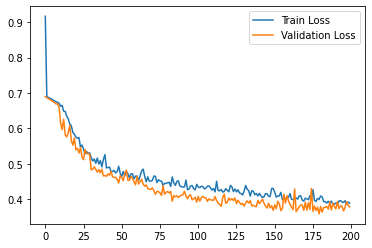

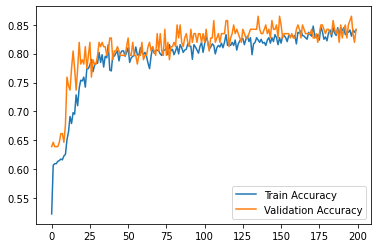

In [31]:
plots(history_model)

In [34]:
predict_data = test(batch_size)
predict_data

PassengerId  Survived
0            892  0.129930
1            893  0.129930
2            894  0.129930
3            895  0.129930
4            896  0.514084
..           ...       ...
413         1305  0.129930
414         1306  0.998743
415         1307  0.129930
416         1308  0.129930
417         1309  0.129930

[418 rows x 2 columns]

In [35]:
new_pred = []
for i in predict_data["Survived"]:
    
    if i >=0.6:
        new_pred.append(1)
    else:
        new_pred.append(0)

In [37]:
test=pd.read_csv('test.csv')
test_ids=test['PassengerId']

In [38]:
predict_survived = pd.DataFrame()
predict_survived['PassengerId'] = test_ids
predict_survived['Survived'] = new_pred
predict_survived

PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]

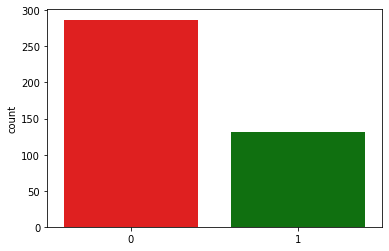

In [39]:
plt.figure()
sns.countplot(new_pred,palette=('red','green'))
plt.show()

In [43]:
predict_survived.to_csv('out.csv',index=False)